# LangGraph Message Management: Filter and Trim Messages | Memory - In memory and local db - Python Cookbook

### llm

In [11]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()

llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash',temperature=0)


### State - Message from Langchain

In [12]:

from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, trim_messages

from langgraph.graph.message import add_messages, RemoveMessage

messages = [AIMessage(f"Did you watch the game on 2024 IPL Final?", name="Gemini")]
messages.append(HumanMessage(f"Not ringing a bell. Can you tell me what happened?", name="Alice"))

for m in messages:
	m.pretty_print()

================================== Ai Message ==================================
Name: Gemini

Did you watch the game on 2024 IPL Final?
================================ Human Message =================================
Name: Alice

Not ringing a bell. Can you tell me what happened?


In [13]:
llm.invoke(messages)

AIMessage(content='The Kolkata Knight Riders (KKR) won the 2024 IPL final, defeating the Sunrisers Hyderabad (SRH) quite convincingly. It was a dominant performance by KKR. They bowled SRH out for a very low score and then chased it down with ease.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--63bdad29-7ab7-4a54-a11b-9d2a6dc39e1b-0', usage_metadata={'input_tokens': 26, 'output_tokens': 59, 'total_tokens': 85, 'input_token_details': {'cache_read': 0}})

### Node

In [14]:
from langgraph.graph import MessagesState

def chat_model_node(state: MessagesState):
	return {"messages": llm.invoke(state["messages"])}

### Lets build a graph

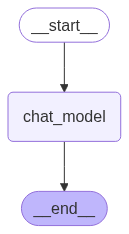

In [15]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
# simple invoke with all messages

out = graph.invoke({"messages": messages})
for msg in out["messages"]:
		msg.pretty_print()

================================== Ai Message ==================================
Name: Gemini

Did you watch the game on 2024 IPL Final?
================================ Human Message =================================
Name: Alice

Not ringing a bell. Can you tell me what happened?
================================== Ai Message ==================================

The Kolkata Knight Riders (KKR) won the 2024 IPL final, defeating the Sunrisers Hyderabad (SRH) quite convincingly. KKR bowled SRH out for just 113 and then chased down the target with ease, winning by 8 wickets. It was a dominant performance by KKR.


### adding reducers

#### 1. Filter Message

In [17]:
def filter_messages(state: MessagesState):
	delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
	return {"messages": delete_messages}

### rebuild the graph

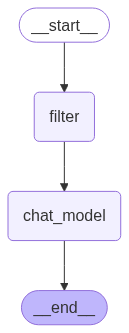

In [18]:
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
messages = [AIMessage("Hi.", name="Gemini", id="1")]
messages.append(HumanMessage("Hi.", name="Alice", id="2"))
messages.append(AIMessage("How are you?", name="Gemini", id="3"))
messages.append(HumanMessage("I am good, can we talk about IPL 2024 final.", name="Alice", id="4"))
out = graph.invoke({"messages": messages})
for msg in out["messages"]:
		msg.pretty_print()

================================== Ai Message ==================================
Name: Gemini

How are you?
================================ Human Message =================================
Name: Alice

I am good, can we talk about IPL 2024 final.
================================== Ai Message ==================================

Great! I'm doing well too, and I'd love to talk about the IPL 2024 final. It was quite a match!

To get us started, what specifically are you interested in discussing? For example, are you curious about:

*   **The key moments of the match?**
*   **The winning team's strategy?**
*   **The performance of specific players?**
*   **The overall atmosphere and fan experience?**
*   **Controversies or talking points from the game?**
*   **Predictions for next season based on the final?**

Let me know what's on your mind, and I'll do my best to provide insights and information.


#### 2. Trim Messages
- this is based on tokens primarily

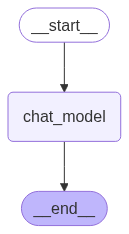

In [20]:
from langchain_core.messages.utils import count_tokens_approximately
def chat_model_node(state: MessagesState):
		messages = trim_messages(
			messages=state["messages"], 
			max_tokens=50, 
			strategy='last', 
			token_counter=ChatGoogleGenerativeAI(model='gemini-2.5-flash')
		)
		return {"messages": [llm.invoke(messages)]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
messages = [*messages, *out['messages']]
messages.append(HumanMessage(f"Tell me where penguins live!", name="Alice"))
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Gemini', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Alice', id='2'),
 AIMessage(content='How are you?', additional_kwargs={}, response_metadata={}, name='Gemini', id='3'),
 HumanMessage(content='I am good, can we talk about IPL 2024 final.', additional_kwargs={}, response_metadata={}, name='Alice', id='4'),
 AIMessage(content='How are you?', additional_kwargs={}, response_metadata={}, name='Gemini', id='3'),
 HumanMessage(content='I am good, can we talk about IPL 2024 final.', additional_kwargs={}, response_metadata={}, name='Alice', id='4'),
 AIMessage(content="Great! I'm doing well too, and I'd love to talk about the IPL 2024 final. It was quite a match!\n\nTo get us started, what specifically are you interested in discussing? For example, are you curious about:\n\n*   **The key moments of the match?**\n*   **The winning team's strategy?**\n*   **The performance of

In [22]:
trim_messages(
			messages=messages, 
			max_tokens=10, 
			strategy='last', 
			token_counter=count_tokens_approximately
		)


[]

In [23]:
messages_out_trim = graph.invoke({'messages': messages})
for msg in messages_out_trim['messages']:
		msg.pretty_print()

================================== Ai Message ==================================
Name: Gemini

Hi.
================================ Human Message =================================
Name: Alice

Hi.
================================== Ai Message ==================================
Name: Gemini

How are you?
================================ Human Message =================================
Name: Alice

I am good, can we talk about IPL 2024 final.
================================== Ai Message ==================================

Great! I'm doing well too, and I'd love to talk about the IPL 2024 final. It was quite a match!

To get us started, what specifically are you interested in discussing? For example, are you curious about:

*   **The key moments of the match?**
*   **The winning team's strategy?**
*   **The performance of specific players?**
*   **The overall atmosphere and fan experience?**
*   **Controversies or talking points from the game?**
*   **Predictions for next season based on 

### Memory management - Adding memory and managing context window - summarization

In [24]:
from typing import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage

from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [25]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage


def chat_node(state: State):
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of our conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}



In [26]:
def summarize_conversation(state: State):
    summary = state.get('summary', '')

    if summary:
        print("Updating summary")
        summary_msg = HumanMessage(
            content=f"This is the summary of our conversation: {summary}"
        )
    else:
        print("Creating summary")
        summary_msg = HumanMessage(
            content="Create a summary of the above conversation: "
        )
    all_msgs = state['messages']
    messages = all_msgs + [summary_msg]
    res = llm.invoke(messages)
    return {
        'summary': res.content,
        'messages': [RemoveMessage(id=m.id) for m in all_msgs[:-2]]
    }

In [27]:
from langgraph.graph import END
def should_continue(state: MessagesState):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 4:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

#### adding db memory

In [28]:
import sqlite3

!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(":memory:", check_same_thread = False)


In [29]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

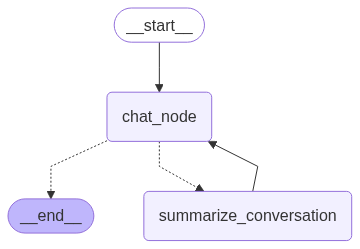

In [30]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("chat_node", chat_node)
workflow.add_node("summarize_conversation", summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "chat_node")
workflow.add_conditional_edges("chat_node", should_continue, {  # Use should_continue instead of summarize_conversation
    "summarize_conversation": "summarize_conversation",
    END: END
})
workflow.add_edge("summarize_conversation", "chat_node")  # Add edge back to chat_node after summarizing

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "1"}}

# add more messages so, we summarize the conversation

sample_messages = [
    HumanMessage(content="hi! I'm Alice"),
    AIMessage(content="Hi, Alice! How can I help you today?"),
    HumanMessage(content="I'm looking for a new laptop"),
    AIMessage(content="Sure, I can help you with that. What kind of laptop are you looking for?"),
    HumanMessage(content="I need a laptop with a good battery life and a good processor"),
    AIMessage(content="I understand. What's your budget?"),
    HumanMessage(content="I'm looking for a laptop under $1000"),
]

# invoke the graph with the sample messages
out = graph.invoke({"messages": sample_messages}, config)
for m in out['messages']:
    m.pretty_print()


Creating summary
================================ Human Message =================================

I'm looking for a laptop under $1000
================================== Ai Message ==================================

Okay, a laptop under $1000 with good battery life and a good processor. That's definitely doable! To give you the best recommendations, I need a little more information.  Could you tell me about:

*   **What will you primarily use the laptop for?** (e.g., schoolwork, work from home, gaming, video editing, general browsing, etc.)
*   **What size screen are you looking for?** (e.g., 13-inch, 15-inch, 17-inch)
*   **Do you have any preferred operating systems?** (Windows, macOS, ChromeOS)
*   **Do you need a lot of storage space?** (e.g., for photos, videos, games)
*   **Are there any specific brands you prefer or dislike?**

Once I have this information, I can give you some tailored recommendations. In the meantime, here are a few general options that often come up in this 

In [32]:
out = graph.invoke({"messages": [HumanMessage(content="hi! I'm Alice")]}, config) 
for m in out['messages']:
    m.pretty_print()

out = graph.invoke({"messages": [HumanMessage(content="what's my name?")]}, config) 
for m in out['messages']:
    m.pretty_print()

out = graph.invoke({"messages": [HumanMessage(content="i like the 49ers!")]}, config) 
for m in out['messages']:
    m.pretty_print()

Updating summary
================================ Human Message =================================

hi! I'm Alice
================================== Ai Message ==================================

Hi Alice! It's nice to meet you. I'm here to help you find the perfect laptop. I'll keep that in mind as we discuss your needs and preferences. Let's get you set up with a great new machine!
================================== Ai Message ==================================
Updating summary
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Alice!
================================== Ai Message ==================================
Updating summary
================================ Human Message =================================

i like the 49ers!
================================== Ai Message ==================================

Okay, Alice! You like the 49ers. Got

In [33]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='i like the 49ers!', additional_kwargs={}, response_metadata={}, id='6b5dad7c-f65e-478b-a918-5f1ab8166d76'), AIMessage(content="Okay, Alice! You like the 49ers. Got it! I'll keep that in mind as we move forward. Does your preference for the 49ers have any bearing on what you're looking for in a laptop? (e.g., needing to stream games on the go, wanting a laptop with a specific color scheme, etc.) Or is it just a fun fact? Let me know!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--4ee318ad-02b4-49a8-b59c-4cbd5c99a222-0', usage_metadata={'input_tokens': 98, 'output_tokens': 87, 'total_tokens': 185, 'input_token_details': {'cache_read': 0}}), AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP